# Key-Value Attention for Thai Karaoke Character-level Machine Translation (Many-to-Many, encoder-decoder)

In this homework, you will create an MT model with attention mechnism that coverts names of Thai 2019 MP candidates from Thai script to Roman(Latin) script. E.g. นิยม-->niyom

The use of Pytorch Lightning is optional but recommended. You can use Pytorch if you prefer.

In [1]:
!pip install lightning wandb
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!wandb login

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: charoonroj-amo (charoonroj-amo-chulalongkorn-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
%matplotlib inline
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
mpl.rc('font', family='TH Sarabun New')
import torch
# import torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import lightning as L
import numpy as np

import random

## Load Dataset
We have generated a toy dataset using names of Thai MP candidates in 2019 Thai General Election from elect.in.th's github(https://github.com/codeforthailand/dataset-election-62-candidates) and tltk (https://pypi.org/project/tltk/) library to convert them into Roman script.

```
ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak
```


In [4]:
!wget https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv

--2025-05-31 13:25:38--  https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324399 (317K) [text/plain]
Saving to: ‘mp_name_th_en.csv’

mp_name_th_en.csv   100%[===================>] 316.80K  --.-KB/s    in 0.02s   

2025-05-31 13:25:38 (17.9 MB/s) - ‘mp_name_th_en.csv’ saved [324399/324399]



In [5]:
import csv

with open('mp_name_th_en.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    name_th = []
    name_en = []
    for row in readCSV:
        temp_th = row[0]
        temp_en = row[1]

        name_th.append(temp_th)
        name_en.append(temp_en)

In [6]:
for th, en in zip(name_th[:10],name_en[:10]):
    print(th,en)

ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak


## TODO1: Preprocess dataset
* You will need 2 vocabularies (1 for input and another for output)
* DON'T FORGET TO INCLUDE special token for padding (for both input and output)
* DON'T FORGET TO INCLUDE special token for the end of word symbol (output)

In [7]:
#Preprocessing
input_chars = list(set(''.join(name_th)))
output_chars = list(set(''.join(name_en)))
data_size, vocab_size = len(name_th), len(input_chars)+1
output_vocab_size = len(output_chars)+2#+2 for special end of sentence token/PADDING
print('There are %d lines and %d unique characters in your input data.' % (data_size, vocab_size))
maxlen = len( max(name_th, key=len)) #max input length
maxlen_out = len( max(name_en, key=len)) #max input length

There are 10887 lines and 65 unique characters in your input data.


In [8]:
print("Max input length:", maxlen)
print("Max output length:", maxlen_out)

Max input length: 20
Max output length: 19


In [11]:
sorted_chars = sorted(input_chars)
sorted_chars.insert(0, "<PAD>")
# sorted_chars.insert(1, "</s>")

sorted_output_chars = sorted(output_chars)
sorted_output_chars.insert(0, "<PAD>")
sorted_output_chars.insert(1, "</s>")

input_stoi = { c:i for i, c in enumerate(sorted_chars) }
input_itos = { i:c for i, c in enumerate(sorted_chars)}
input_encode = lambda sentence: [input_stoi[c] for c in sentence]
input_decode = lambda encoding: "".join([input_itos[i] for i in encoding])

output_stoi = { c:i for i, c in enumerate(sorted_output_chars) }
output_itos = { i:c for i, c in enumerate(sorted_output_chars)}
output_encode = lambda sentence: [output_stoi[c] for c in sentence]
output_decode = lambda encoding: "".join([output_itos[i] for i in encoding])

print(input_encode(name_th[0]))
print(input_decode(input_encode(name_th[0])))

[58, 2, 34, 39, 49, 40, 64]
ไกรสีห์


In [12]:
print(input_stoi)
print(output_stoi)

{'<PAD>': 0, ' ': 1, 'ก': 2, 'ข': 3, 'ค': 4, 'ฆ': 5, 'ง': 6, 'จ': 7, 'ฉ': 8, 'ช': 9, 'ซ': 10, 'ฌ': 11, 'ญ': 12, 'ฎ': 13, 'ฏ': 14, 'ฐ': 15, 'ฑ': 16, 'ฒ': 17, 'ณ': 18, 'ด': 19, 'ต': 20, 'ถ': 21, 'ท': 22, 'ธ': 23, 'น': 24, 'บ': 25, 'ป': 26, 'ผ': 27, 'ฝ': 28, 'พ': 29, 'ฟ': 30, 'ภ': 31, 'ม': 32, 'ย': 33, 'ร': 34, 'ล': 35, 'ว': 36, 'ศ': 37, 'ษ': 38, 'ส': 39, 'ห': 40, 'ฬ': 41, 'อ': 42, 'ฮ': 43, 'ะ': 44, 'ั': 45, 'า': 46, 'ำ': 47, 'ิ': 48, 'ี': 49, 'ึ': 50, 'ื': 51, 'ุ': 52, 'ู': 53, 'เ': 54, 'แ': 55, 'โ': 56, 'ใ': 57, 'ไ': 58, '็': 59, '่': 60, '้': 61, '๊': 62, '๋': 63, '์': 64}
{'<PAD>': 0, '</s>': 1, '-': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'w': 22, 'y': 23}


In [14]:
X = []
for line in name_th:
    X.append(torch.tensor(input_encode(line)))
Y = []
for line in name_en:
    Y.append(torch.tensor(output_encode(line)))

X = nn.utils.rnn.pad_sequence(X, batch_first=True)
Y = nn.utils.rnn.pad_sequence(Y, batch_first=True)

In [16]:
Ty = len(max(Y, key=len))
Ty

19

In [15]:
from torch.utils.data import Dataset, DataLoader
from torch.types import Tensor

In [10]:
class NameDataset(Dataset):
  def __init__(self, X, y):
    self.encoded = X
    self.label = y

  def __getitem__(self, idx):
    return {"x": self.encoded[idx], "y": self.label[idx]}

  def __len__(self):
    return len(self.encoded)

In [13]:
class NameDataModule(L.LightningDataModule):

  def __init__(self, train_data, y, batch_size, num_workers=0):
      super().__init__()
      self.train_data = train_data
      self.y = y
      self.batch_size = batch_size
      self.num_workers = num_workers


  def setup(self, stage: str):
    pass

  def collate_fn(self, batch):
    one_hot_x = torch.stack([F.one_hot(b["x"], num_classes=len(input_stoi)) for b in batch])
    return {"x": one_hot_x.float(), "y": torch.stack([b["y"] for b in batch])}

  def train_dataloader(self):
    train_dataset = NameDataset(self.train_data, self.y)
    train_loader = DataLoader(train_dataset,
                              batch_size=self.batch_size,
                              shuffle=True,
                              collate_fn=self.collate_fn,
                              num_workers=self.num_workers)
    return train_loader


# Attention Mechanism


## TODO 2: Code your own (key-value) attention mechnism
* PLEASE READ: you DO NOT have to follow all the details in (Daniluk, et al. 2017). You just need to create a key-value attention mechanism where the "key" part of the mechanism is used for attention score calculation, and the "value" part of the mechanism is used to encode information to create a context vector.  
* fill code for one_step_attention function



In [30]:
def one_step_attention(h: Tensor, s_prev: Tensor, linear_1: nn.Linear, linear_2: nn.Linear):
    # (enc) h.shape = batch, seq_len, hidden_dim
    # (dec) s_prev.shape = batch, hidden_dim

    #Split into Key-Value
    hidden_dim = h.shape[-1]
    key_dim = hidden_dim // 2
    value_dim = key_dim
    key, value = torch.split(h, [key_dim, value_dim], dim=-1)

    seq_len = h.shape[1]
    #do concat with s_prev.
    s_prev = s_prev.unsqueeze(1).repeat(1, seq_len, 1)
    concat = torch.cat([key, s_prev], dim=-1)
    #hint: you will need to use s_prev.repeat(...) somehow so that it has the same dimension as the key
    #hint2: s_prev.unsqueeze() could also be useful

    #Attention function###
    # use layer(s) from your model to calculate attention_scores and then softmax
    # calculate a context vector
    e = F.tanh(linear_1(concat))
    energies = F.relu(linear_2(e))
    attention_scores = F.softmax(energies, dim=1)
    context = torch.sum(attention_scores * value, dim=1)

    return context, attention_scores

# Translation Model

## TODO3: Create and train your encoder/decoder model here

In [44]:
output_vocab = output_stoi
class AttentionModel(L.LightningModule):
    def __init__(self, learning_rate, criterion):

        super().__init__()
        self.n_h = 32 #hidden dimensions for encoder
        self.n_s = 64 #hidden dimensions for decoder
        self.learning_rate = learning_rate
        self.criterion = criterion

        #encoder can be any RNN of your choice
        bidirection = True
        self.num_directions = 2 if bidirection else 1
        self.lstm = nn.LSTM(len(input_stoi), self.n_h, bidirectional=bidirection, batch_first=True)

        #decoder has to be (any) RNNCell since we will need to calculate attention for each timestep manually
        self.decoder_lstm_cell = nn.LSTMCell(self.n_s//2, self.n_s)
        self.output_layer = nn.Linear(self.n_s, len(output_stoi))

        #attention
        self.fc1 = nn.Linear(self.n_h*self.num_directions*3//2, self.n_h)
        self.fc2 = nn.Linear(self.n_h, 1)

    def forward(self, src, return_attention=False): #use return_attention only when you want to get the attention scores for visualizing
        #pass the input to the encoder
        lstm_out, _ = self.lstm(src)

        #Initialize the LSTM states. We have to do this since we are using LSTMCell (https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html)
        #These states will get updated while we are decoding
        decoder_s = torch.randn(src.shape[0], self.n_s).to(self.decoder_lstm_cell.weight_ih.device)
        decoder_c = torch.randn(src.shape[0], self.n_s).to(self.decoder_lstm_cell.weight_ih.device)

        #Iterate until max_output_length (Decoding)
        prediction = torch.zeros((src.shape[0], Ty, len(output_vocab))).to(self.decoder_lstm_cell.weight_ih.device)
        attention_scores = [] #to store the score for each step
        for t in range(Ty):

            #Perform one step of the attention mechanism to calculate the context vector at timestep t
            context, attention_score = one_step_attention(lstm_out, decoder_s, self.fc1, self.fc2)

            # Feed the context vector to the decoder.
            decoder_s, decoder_c = self.decoder_lstm_cell(context, (decoder_s, decoder_c))
            # Pass the decoder hidden output to the output layer (softmax)
            out = self.output_layer(decoder_s)
            # Put the predicted output into the list for this timestep
            prediction[:, t] = out
            attention_scores.append(attention_score)

        return (prediction, attention_scores if return_attention else None)

    def training_step(self, batch, batch_idx):
        src = batch['x']
        target = batch['y']
        prediction,_ = self(src)
        prediction = prediction.reshape(-1, len(output_vocab))
        target = target.reshape(-1)
        loss = self.criterion(prediction, target)
        self.log("train_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        src = batch['x']
        with torch.no_grad():
          prediction, attention_scores = self(src, return_attention=True)
          prediction = F.softmax(prediction, dim=-1)
          prediction = torch.argmax(prediction, dim=-1)
          for pred in prediction:
            print("".join(output_decode(pred.cpu().numpy())))
            # print("".join(output_vocab.lookup_tokens(pred.cpu().numpy())))
        return prediction, attention_scores

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

In [51]:
criterion = nn.CrossEntropyLoss()
lr = 0.01
model = AttentionModel(lr,criterion)

In [52]:
data_module = NameDataModule(X, Y, batch_size = 4096)

In [53]:
from lightning import Trainer
from lightning.pytorch.loggers import WandbLogger
wandb_logger = WandbLogger(project="hw3.1_attention")

In [54]:
trainer = L.Trainer(
    max_epochs=300,
    logger=wandb_logger
)

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [55]:
trainer.fit(model, data_module)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory ./hw3.1_attention/jzcx57tz/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | criterion         | CrossEntropyLoss | 0      | train
1 | lstm              | LSTM             | 25.3 K | train
2 | decoder_lstm_cell | LSTMCell         | 25.1 K | train
3 | output_layer      | Linear           | 1.6 K  | train
4 | fc1               | Linear           | 3.1 K  | train
5 |

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=300` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


# Test Your Model

## TODO4: Test your model on 5 examples of your choice including your name!

Example Output:
```
prayutthatha</s></s>aa</s></s>a</s>
somchai</s></s></s></s>a</s></s>a</s></s></s></s></s>
thanathon</s></s></s></s></s></s></s></s></s></s></s>
newin</s>i</s></s></s></s></s></s></s></s></s></s></s></s></s>
suthep</s>he</s></s></s></s></s></s></s></s></s></s></s>
prawit</s></s></s></s></s></s></s></s></s></s></s></s></s></s>
chatchachatti</s></s>i</s></s></s></s>
```

<font color='blue'>Paste your model predictions in MyCourseVille</font>

In [56]:
EXAMPLES = ['ประยุทธ์','สมชาย','ธนาธร','เนวิน','สุเทพ','ประวิตร์','ชัชชาติ','จรูญโรจน์']
predict_data = []
for line in EXAMPLES:
    line = [l for l in line] #change from string to list
    predict_data.append(torch.tensor(input_encode(line)))

print(len(predict_data))
def collate_fn(batch):
    one_hot_x = torch.stack([F.one_hot(b["x"], num_classes=len(input_stoi)) for b in batch])
    return {"x": one_hot_x.float()}

predict_data = nn.utils.rnn.pad_sequence(predict_data, batch_first = True)
predict_dataset = NameDataset(predict_data, torch.tensor([torch.tensor(0)]*len(predict_data)))
predict_loader = DataLoader(predict_dataset,
                          batch_size = 1,
                          shuffle = False,
                          collate_fn = collate_fn,
                          num_workers = 0)

8


In [57]:
model.eval()

AttentionModel(
  (criterion): CrossEntropyLoss()
  (lstm): LSTM(65, 32, batch_first=True, bidirectional=True)
  (decoder_lstm_cell): LSTMCell(32, 64)
  (output_layer): Linear(in_features=64, out_features=24, bias=True)
  (fc1): Linear(in_features=96, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [59]:
output = trainer.predict(model, predict_loader)

prediction, attention_scores = zip(*output)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

prayut<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
somchai<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
thanathon<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
nawin<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
suthep<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
prawit<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
chatchachatti<PAD><PAD><PAD><PAD><PAD><PAD>
carunrot<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>


## TODO 5: Show your visualization of attention scores on one of your example

<font color='blue'>Paste your visualization image in MyCourseVille</font>

In [60]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
prediction, attention_scores = zip(*output)

In [64]:
sample_pred = prediction[-1]
sample_pred = [p for p in sample_pred.cpu().numpy().tolist()[0] if p != 0]
sample_attention_scores = attention_scores[-1]

attn_viz = torch.stack(sample_attention_scores).squeeze().cpu().numpy()
attn_viz = attn_viz[:len(EXAMPLES[-1])+1, :len(sample_pred)+1]

output_text = [c for c in output_decode(sample_pred)]
output_text.append("<PAD>")
xlabels = [c for c in EXAMPLES[-1]]
xlabels.append("<PAD>")
print(output_text, xlabels)
print(attn_viz.shape, len(EXAMPLES[-1]), len(sample_pred))
print(attn_viz)

['c', 'a', 'r', 'u', 'n', 'r', 'o', 't', '<PAD>'] ['จ', 'ร', 'ู', 'ญ', 'โ', 'ร', 'จ', 'น', '์', '<PAD>']
(10, 9) 9 8
[[9.9928349e-01 8.9558867e-05 8.9558867e-05 8.9558867e-05 8.9558867e-05
  8.9558867e-05 8.9558867e-05 8.9558867e-05 8.9558867e-05]
 [6.1774105e-01 3.7679929e-01 2.7934171e-03 1.4028987e-03 1.3229156e-04
  4.5092497e-04 1.5566275e-04 2.2478694e-04 2.9981640e-04]
 [2.3253502e-02 9.3890035e-01 2.6930373e-02 8.1430255e-03 2.0184080e-04
  1.1841328e-03 4.5088105e-04 5.6733954e-04 3.6846986e-04]
 [2.5024993e-02 1.3561012e-01 6.9101131e-01 1.1356207e-01 3.1715676e-03
  1.3251024e-02 5.4792147e-03 6.1255656e-03 6.7640557e-03]
 [1.4174275e-02 2.7571624e-02 2.3481464e-01 6.0327363e-01 3.9299605e-03
  8.9811459e-02 7.8287851e-03 8.5649872e-03 1.0030669e-02]
 [5.8095353e-03 1.9588512e-03 3.7338335e-02 2.1840231e-01 1.6503515e-02
  6.5303516e-01 2.6590124e-02 2.0940447e-02 1.9421710e-02]
 [3.5427902e-03 8.8361284e-04 1.4172532e-02 4.8981719e-02 2.3640496e-01
  4.5784041e-01 1.2545796

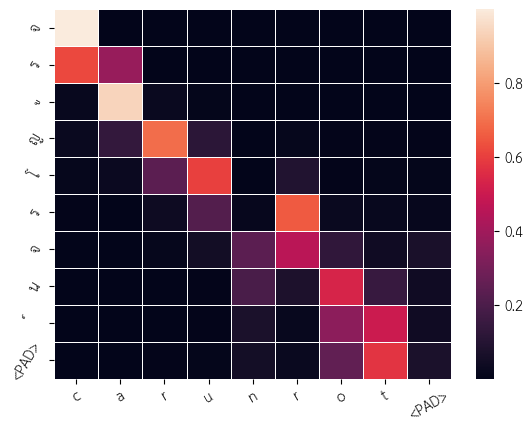

In [65]:
ax = sns.heatmap(attn_viz, linewidth=0.5)
ax.set_xticklabels(output_text,rotation=30)
ax.set_yticklabels(xlabels,rotation=60)
plt.show()